# Case Study 8 - XGBoost, Random Forest and SVM

Allen Ansari, Chris Ballenger, Shantanu Godbole, Chad Madding

DS 7333 Quantifying the World

June 29, 2020

___

## Table of Contents
1. [Abstract & Introduction](#Abstract)
2. [Data](#Data)
3. [EDA and Feature Reduction](#EDA)
4. [Evaluate the Response Variable](#Evaluate-the-Response)
5. [Question 1](#Question-1)

___

## Abstract  
During this project, we look to improve accuracy by exploring hypter tunning an XGBoost, a Random Forest, and a Support Vector Machine model.  The data used is provided through a kaggle competition and has already been "cleaned" for our project consumption. *Provide overall result*

### Introduction

As a global specialist in personal insurance, BNP Paribas Cardif serves 90 million clients in 36 countries across Europe, Asia and Latin America.

In a world shaped by the emergence of new uses and lifestyles, everything is going faster and faster. When facing unexpected events, customers expect their insurer to support them as soon as possible. However, claims management may require different levels of check before a claim can be approved and a payment can be made. With the new practices and behaviors generated by the digital economy, this process needs adaptation thanks to data science to meet the new needs and expectations of customers.
<sup><sub>https://www.kaggle.com/c/bnp-paribas-cardif-claims-management</sub></sup>

In order to achieve the highest accuracy we will explore hypertuning our models in order to find the optimal parameter that balances accuracy, log loss, and time.  While accuracy is important, we need to balance how much time this takes as a measurment in order to react faster to the change climax of insurance policies.

Our report will be broken is 3 sections, modeling, measurment, and time.
*Case Study Questions
* [Build and tune](#Hyper-Tuning-Models) three machine learning models: An XGBoost, a Random Forest, and an SVM to predict a given target.  
* [Show](#Results) the log loss and accuracy for XGBoost and Random Forest models on out of fold predictions. Show the Accuracy of the SVM on a validation set.
* [Time](#Support-Vector-Machine-Scale) how long it takes to do a sample of 1000, 2000, 5000, and 10,000 rows in the SVM and report the rough scaling of SVM with the sample sizes.  


[Back to Top](#Table-of-Contents)

____

## Data

Our team has been given an anonymized dataset containing both categorical and numeric variables available form the following site:  

https://smu.box.com/s/bizpcq4a3dtid04tke1x7nz7359r79y5  


The original size of the data set is 114321 rows and 133 columns.
There is no missing data, no metadata, no ordinal variables or a data dictionary.  
The "target" column in the set is the variable to predict. It is equal to 1 for claims suitable for an accelerated approval.
<sup><sub>https://www.kaggle.com/c/bnp-paribas-cardif-claims-management/data</sub></sup>



In [17]:
import pandas as pd

case_8 = pd.read_csv("~/Dropbox/Case_Study_8/case_8.csv")

print("Data Size", case_8.shape)
print("Drop ID and Target")

## For plotting 
lables = case_8.target

y = case_8.target.values

case_8.drop(["ID","target"], axis=1, inplace=True)
print("Data Size", case_8.shape)

case_8.head()

Data Size (114321, 133)
Drop ID and Target
Data Size (114321, 131)


,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,1.335739,8.727474,C,3.921026,7.915266,2.599278,3.176895,0.012941,9.999999,0.503281,...,8.000000,1.989780,0.035754,AU,1.804126,3.113719,2.024285,0,0.636365,2.857144
1,1.630686,7.464411,C,4.145098,9.191265,2.436402,2.483921,2.301630,9.031859,1.312910,...,6.822439,3.549938,0.598896,AF,1.672658,3.239542,1.957825,0,1.925763,1.739389
2,0.943877,5.310079,C,4.410969,5.326159,3.979592,3.928571,0.019645,12.666667,0.765864,...,9.333333,2.477596,0.013452,AE,1.773709,3.922193,1.120468,2,0.883118,1.176472
3,0.797415,8.304757,C,4.225930,11.627438,2.097700,1.987549,0.171947,8.965516,6.542669,...,7.018256,1.812795,0.002267,CJ,1.415230,2.954381,1.990847,1,1.677108,1.034483
4,1.630686,7.464411,C,4.145098,8.742359,2.436402,2.483921,1.496569,9.031859,1.050328,...,6.822439,3.549938,0.919812,Z,1.672658,3.239542,2.030373,0,1.925763,1.739389


____
[Back to Top](#Table-of-Contents)

## EDA

Throug our analysis, we found 19 Categorical Variables and 112 continouse variables.  Further details of our categorical variables shows column `v22` has 18,210 unique values.  Additional research has shown this to be a username field.  We decided to remove this field for its large unique fields.

In [18]:
cols = case_8.dtypes
print("Total Catagorical Variables", sum(cols == "object"))
print("Total Catagorical Variables", sum(cols != "object"))

columns = case_8.loc[:,cols == "object"].columns

print("Unique Values per catogorical column")
display( case_8[columns].apply(lambda x: len(x.value_counts())) )

print("Drop v22")
case_8_data_prep = case_8.drop(["v22"], axis=1)
columns = columns[columns != "v22"]
print("Data Size", case_8_data_prep.shape)

Total Catagorical Variables 19
Total Catagorical Variables 112
Unique Values per catogorical column


v3          3
v22     18210
v24         5
v30         7
v31         3
v47        10
v52        12
v56       122
v66         3
v71         9
v74         3
v75         4
v79        18
v91         7
v107        7
v110        3
v112       22
v113       36
v125       90
dtype: int64

Drop v22
Data Size (114321, 130)


In order to do our modeling, we need to One Hot Encode each of our categorical variables.  We have created 364 new columns from One-Hot Encoding technique, combined with the continouse gives us a 476 columns.

In [19]:
from tqdm import tqdm

data = [ pd.get_dummies(case_8_data_prep[col], prefix=col).copy() for col in tqdm(columns) ]
one_hot_df = pd.concat(data, axis=1)

display("New Columns derived from categorical", one_hot_df.shape)

100%|██████████| 18/18 [00:00<00:00, 78.53it/s]


'New Columns derived from categorical'

(114321, 364)

In [20]:
#Drop old columns
case_8_final = case_8_data_prep.drop(columns, axis=1)

#Concat Original and One-Hot Data Frame
case_8_final = pd.concat([case_8_final, one_hot_df], axis=1)
case_8_data_prep = None #take out of memory

print(case_8_final.shape)
display(case_8_final.head())

(114321, 476)


,v1,v2,v4,v5,v6,v7,v8,v9,v10,v11,...,v125_Q,v125_R,v125_S,v125_T,v125_U,v125_V,v125_W,v125_X,v125_Y,v125_Z
0,1.335739,8.727474,3.921026,7.915266,2.599278,3.176895,0.012941,9.999999,0.503281,16.434108,...,0,0,0,0,0,0,0,0,0,0
1,1.630686,7.464411,4.145098,9.191265,2.436402,2.483921,2.301630,9.031859,1.312910,15.447413,...,0,0,0,0,0,0,0,0,0,0
2,0.943877,5.310079,4.410969,5.326159,3.979592,3.928571,0.019645,12.666667,0.765864,14.756098,...,0,0,0,0,0,0,0,0,0,0
3,0.797415,8.304757,4.225930,11.627438,2.097700,1.987549,0.171947,8.965516,6.542669,16.347483,...,0,0,0,0,0,0,0,0,0,0
4,1.630686,7.464411,4.145098,8.742359,2.436402,2.483921,1.496569,9.031859,1.050328,15.447413,...,0,0,0,0,0,0,0,0,0,1


### Feature Reduction

In order to improve time for training, we first reduced highly correlated values.  In other words, columns that almost mimic each other and provide no additional value.  The function we will use is called `reduce_features` and can be found in the [Appendix](#Appendix).  The function is designed to evaluate pairwise correlation and remove one of the columns if the Pearson Correlation is greater than 0.95.

In [21]:
%%time

import pickle
import os

case_8_reduced_feats = reduce_features(case_8_final, True)

There are  46  field correlations > 95%.


,Field1,Field2,Correlation
0,v46,v8,0.975192
1,v63,v8,0.975974
2,v53,v11,0.955757
3,v64,v17,0.982626
4,v76,v17,0.992671
5,v46,v25,0.982215
6,v54,v25,0.967925
7,v63,v25,0.981040
8,v89,v25,0.964606
9,v105,v25,0.962163


Dropping the following  38  highly correlated fields.

*********Before: Dropping Highly Correlated Fields*************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114321 entries, 0 to 114320
Columns: 476 entries, v1 to v125_Z
dtypes: float64(108), int64(4), uint8(364)
memory usage: 137.4 MB


None


*********After: Dropping Highly Correlated Fields**************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114321 entries, 0 to 114320
Columns: 438 entries, v1 to v125_Z
dtypes: float64(88), int64(4), uint8(346)
memory usage: 118.0 MB
CPU times: user 31.7 s, sys: 177 ms, total: 31.9 s
Wall time: 31.9 s


The remaining modeling will referenced a pickle file created based on the above data process.

____
[Back to Top](#Table-of-Contents)

## Evaluate-the-Response 

In [22]:
with open(os.path.join("data","case_8_final_feats.pkl"),"wb") as f:
    pickle.dump((y, case_8_reduced_feats), f)

1    87021
0    27300
Name: target, dtype: int64

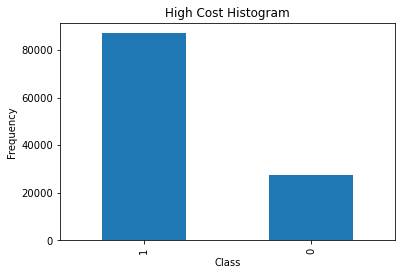

In [27]:
import matplotlib.pyplot as plt
pd.value_counts(lables).plot.bar()
plt.title('High Cost Histogram')
plt.xlabel('Class')
plt.ylabel('Frequency')
lables.value_counts()

#### Accproximately 76% of claims are suitable for accelrated approval.  While we would like to see a more balanced dataset, this value is not extreme. We will proceed implementing stratification, for all the test - train - validation splits to make sure the imbalenced frequency distribution is maintained

In [30]:
print("Claims suitable for accelerated approval (1)", sum(y), round(sum(y) / len(y),4))

Claims suitable for accelerated approval (1) 87021 0.7612


____
[Back to Top](#Table-of-Contents)

## Question-1 : 
#### Build 3 tuned models: An XGBoost, a Random Forest, and an SVM.

###  Hyper Tuning Models

To predict the category of a claim based on features available early in the process we will build 3 tuned models; XGBoost, Random Forest and SVM. We will show the log loss and accuracy for XGBoost, and Random Forest models on out of fold predictions, show the Accuracy of the SVM on a validation set and finaly we will time how long it takes to do a sample of 1000, 2000, 5000, and 10,000 rows in the SVM.  With the data collected during this project we will also be able to provide a rough scaling of SVM with sample sizes.

We will create the train and test set for cross-validation of the results using the train_test_split function from sklearn's model_selection module with test_size size equal to 30% of the data. Also, to maintain the reproducibility of the results, a random_state of 123 will be assigned.

In so doing we will be helping BNP Paribas Cardif accelerate its claims process and therefore provide a better service to its customers.      

*The code used throughout the project is original to this team and modified versions of samples provided during class.*


### Training / Testing Technique

In order to perform a fair test between all regions we will hold out 30% of the data, through a strattified random sample.  We will use this dataset to test our optimal model based on hyper tuning.  We will also do a CV K-Fold of 3 in order to minimize the amount of time some of these models takes to run.

In [11]:
from sklearn.model_selection import train_test_split
import pickle
import pandas as pd
import os

with open(os.path.join("data","case_8_final_feats.pkl"),"rb") as f:
    y, case_8_reduced_feats = pickle.load(f)

X = case_8_reduced_feats.values
    
X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        stratify=y, 
        test_size=0.30,
        random_state=123
    )

## XGBoost

The following parameters were selected for tuning our XGBoost model.  The definitions were provided from https://xgboost.readthedocs.io/en/latest/parameter.html. All the tuning parameters are focused on the boosting aspect of the model.

**Hyper-Tuning Parameters**
* eta (default=0.3, alias: learning_rate, range: [0,1])
    * Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.
* gamma (default=0, alias: min_split_loss, range: [0,∞])
    * Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.
* max_depth (default=6, range: [0,∞] (0 is only accepted in lossguided growing policy when tree_method is set as hist))
    * Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. 0 is only accepted in lossguided growing policy when tree_method is set as hist and it indicates no limit on depth. Beware that XGBoost aggressively consumes memory when training a deep tree.
* min_child_weight (default=1, range: [0,∞])
    * Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning. In linear regression task, this simply corresponds to minimum number of instances needed to be in each node. The larger min_child_weight is, the more conservative the algorithm will be.

**Additional Parameters (Not hyper tuned)**
* objective (default=reg:squarederror)
    * Our model is a Binary classification, thus we will use `binary:logistic`
* metrics
    * We will measure basedo on `logloss` and `auc` (Area Under Curve)
* num_boost_round (defualt=10)
    * We will use 30 rounds
* early_stopping_rounds (default=None)
    * With the large number of boosting rounds, we will stop our model after 3 rounds of no change

In [33]:
import xgboost as xgb
xgtrain = xgb.DMatrix(X_train, y_train)
xgtest = xgb.DMatrix(X_test, y_test)

In [35]:
import itertools
import numpy as np

gamma =  list(np.arange(20, 10, -2))
max_depth = list(np.arange(2, 12, 3))
eta = list(np.arange(0.01, 1, 0.4))
min_child_weight = list(np.arange(0.01, 1, 0.4))
objective="binary:logistic"


parameters = [{"gamma": param[0], "max_depth": param[1], "eta": param[2],"min_child_weight":param[3], "objective": objective}
                  for param in itertools.product(gamma, max_depth, eta, min_child_weight)]

print("Total parameter values to train", len(parameters))

Total parameter values to train 180


The model can be found in the [Appendix](#Appendix).

<img src="XGBoost-time.png" alt="Drawing" align="left" style="width: 500px;"/>

<!-- ![image info](XGBoost-time.png) -->

In [ ]:
xgboost_results = pd.concat(result, axis=0).rename(columns={"index":"rounds"})
xgboost_results["rounds"] = xgboost_results.rounds + 1
xgboost_results.to_csv("data/XGBOOST_Tunning.csv", index=False)

**Top 5 Parameters**

*Values are sorted by `test-logloss-mean`*

In [5]:
import pandas as pd
xgboost_results = pd.read_csv("data/XGBOOST_Tunning.csv")

In [7]:
xgboost_results.sort_values(by=["test-logloss-mean"], ascending=True).head()

,gamma,max_depth,eta,min_child_weight,objective,rounds,train-logloss-mean,train-logloss-std,train-auc-mean,train-auc-std,test-logloss-mean,test-logloss-std,test-auc-mean,test-auc-std
156,12,5,0.41,0.01,binary:logistic,13,0.459897,0.001421,0.766568,0.002063,0.470241,0.002572,0.749903,0.003772
158,12,5,0.41,0.81,binary:logistic,13,0.459897,0.001421,0.766568,0.002063,0.470241,0.002572,0.749903,0.003772
157,12,5,0.41,0.41,binary:logistic,13,0.459897,0.001421,0.766568,0.002063,0.470241,0.002572,0.749903,0.003772
120,14,5,0.41,0.01,binary:logistic,15,0.461842,0.001736,0.763550,0.002530,0.470538,0.002589,0.749045,0.003733
121,14,5,0.41,0.41,binary:logistic,15,0.461842,0.001736,0.763550,0.002530,0.470538,0.002589,0.749045,0.003733


Parameters `gamma`, `max_depth`, and `eta` of 12, 5, and 0.41 respecitvely dominated the as the parameters.  The addition of `min_child_weight` provided no additional value to our best performing model.

**Bottom 5 Parameters**

In [8]:
xgboost_results.sort_values(by=["test-logloss-mean"], ascending=True).tail()

,gamma,max_depth,eta,min_child_weight,objective,rounds,train-logloss-mean,train-logloss-std,train-auc-mean,train-auc-std,test-logloss-mean,test-logloss-std,test-auc-mean,test-auc-std
37,18,2,0.01,0.41,binary:logistic,30,0.616315,0.000222,0.704905,0.001457,0.616484,0.000205,0.702511,0.004011
38,18,2,0.01,0.81,binary:logistic,30,0.616315,0.000222,0.704905,0.001457,0.616484,0.000205,0.702511,0.004011
45,18,5,0.01,0.01,binary:logistic,26,0.615991,0.000487,0.740826,0.001904,0.616562,0.000307,0.735725,0.003046
46,18,5,0.01,0.41,binary:logistic,26,0.615991,0.000487,0.740826,0.001904,0.616562,0.000307,0.735725,0.003046
47,18,5,0.01,0.81,binary:logistic,26,0.615991,0.000487,0.740826,0.001904,0.616562,0.000307,0.735725,0.003046


Further analysis shows decreasing the `eta` had the largest impact to our model's performance.  Below plot shows the average log-loss for each parameter of eta.

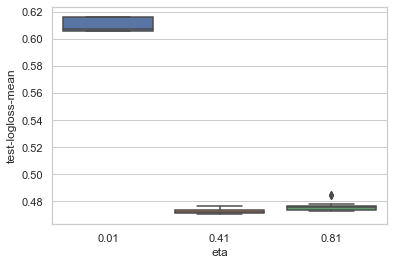

In [83]:
import seaborn as sns
sns.set(style="whitegrid")

sns.boxplot(x="eta", y="test-logloss-mean", data=xgboost_results)

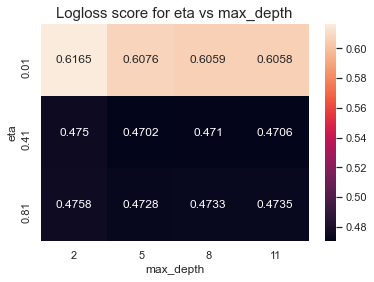

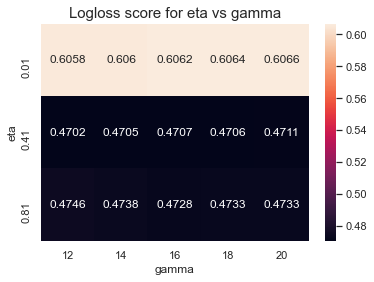

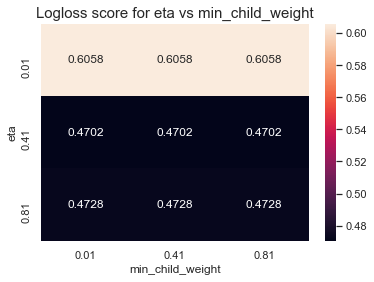

In [157]:
heatmapplot(xgboost_results,'eta','max_depth', 'test-logloss-mean')
heatmapplot(xgboost_results,'eta','gamma', 'test-logloss-mean')
heatmapplot(xgboost_results,'eta','min_child_weight', 'test-logloss-mean')

*Heatmap provides min loglos per combination.*

`eta` also required less rounds to get to an optimal model.

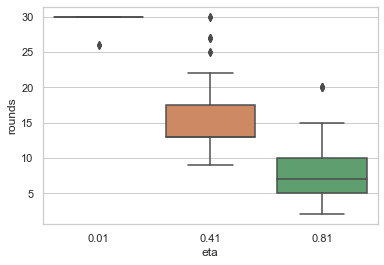

In [103]:
import seaborn as sns
sns.set(style="whitegrid")

sns.boxplot(x="eta", y="rounds", data=xgboost_results)

___

## Random Forest

The follow parameters we selected was a focused on the tree and leaf features.  The definition of the parameters can be found here: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

**Hyper-Tuning Parameters**
* max_features ({“auto”, “sqrt”, “log2”}, int or float, default=”auto”)
    * The number of features to consider when looking for the best split:
* n_estimators (int, default=100)
    * The number of trees in the forest.
* min_samples_leaf (int or float, default=1)
    * The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.
    
*Implementation of RF took 11 minutes, you can find the full code in our Appendix*

```
param_grid = {
    "max_features" : ["auto","log2",0.20, 0.30],
    "n_estimators" : [10,50,100],
    "min_samples_leaf" : [25, 50, 100]
}
```
<img src="Random-Forest-time.png" alt="Drawing" align="left" style="width: 700px;"/>

<!-- ![image info](Random-Forest-time.png) -->

In [203]:
# Load from file
with open("Random Forest/CV_Random_Forest.pkl", 'rb') as file:
    CV_rf = pickle.load(file)

In [204]:
rf_gridsearch = pd.DataFrame(CV_rf.cv_results_)
rf_columns = [
    "param_max_features",
    "param_n_estimators",
    "param_min_samples_leaf",
    "mean_fit_time",
    "mean_test_score",
    "rank_test_score"
]

**Top 10 parameters**

In [294]:
rf_gridsearch[rf_columns].sort_values(by="rank_test_score").head(10)

,param_max_features,param_n_estimators,param_min_samples_leaf,mean_fit_time,mean_test_score,rank_test_score
29,0.3,100,25,269.220127,0.782540,1
28,0.3,50,25,130.805423,0.782190,2
20,0.2,100,25,193.493421,0.781878,3
19,0.2,50,25,95.615099,0.781790,4
32,0.3,100,50,213.482754,0.781616,5
35,0.3,100,100,147.757219,0.781553,6
31,0.3,50,50,118.879127,0.781503,7
23,0.2,100,50,174.869673,0.781503,8
22,0.2,50,50,85.996052,0.781353,9
34,0.3,50,100,109.243511,0.781103,10


Defining the parameter of `max_features` to either 0.2 or 0.3 produced the best result.  From the below boxplot, the parameters for adjust `min_samples_leaf` produced a more consitent result and high mean score.

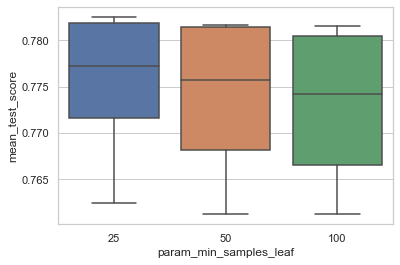

In [185]:
import seaborn as sns
sns.set(style="whitegrid")

sns.boxplot(x="param_min_samples_leaf", y="mean_test_score", data=rf_gridsearch)

**Bottom 5 Parameters**

In [183]:
rf_gridsearch[rf_columns].sort_values(by="rank_test_score").tail()

,param_max_features,param_n_estimators,param_min_samples_leaf,mean_fit_time,mean_test_score,rank_test_score
15,log2,10,100,2.961179,0.761272,32
13,log2,50,50,14.913858,0.761272,32
14,log2,100,50,29.080341,0.761259,34
16,log2,50,100,13.366173,0.761197,35
17,log2,100,100,24.853025,0.761197,35


The parameter `max_features` set to log2 produced the worst scores, but tuning time was significantly faster.  Evaluating the box-plot below we can see log2 was the fastest to tune.

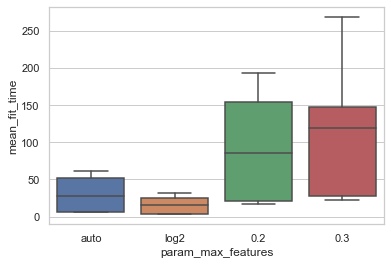

In [186]:
import seaborn as sns
sns.set(style="whitegrid")

sns.boxplot(x="param_max_features", y="mean_fit_time", data=rf_gridsearch)

___

## Support Vector Machine

Scikit Learn has several implementations of Support Vector Machine (SVM).  SVM benefit is that it tries to move values in to a higher dimension (i.e. X^2) in order to classify models.  For the purpose of our exersize, we will use the SKLearn's `LinearSVC` implementation.  This is similar to the SVM algorithm, but uses a linear kernal.  The change allows more flexibility on penalty and loss function, thus allows us a scale better.

Our implementation of SVM uses the `StandardScaler` which will scale our values between -1 and 1.  We chose this in order to allow SVM to consistently measure distance ebtween values.

**Hyper-Tuning Parameters**
https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC
* C (float, default=1.0)
    * Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive.
* loss ({‘hinge’, ‘squared_hinge’}, default=’squared_hinge’)
    * Specifies the loss function. ‘hinge’ is the standard SVM loss (used e.g. by the SVC class) while ‘squared_hinge’ is the square of the hinge loss.
* dual (bool, default=True)
    * Select the algorithm to either solve the dual or primal optimization problem. Prefer dual=False when n_samples > n_features.
* tol (float, default=1e-4)
    * Tolerance for stopping criteria.
* max_iter (int, default=1000)
    * The maximum number of iterations to be run.
    
**Additional Parameters (Not hyper tuned)**
* penalty ({‘l1’, ‘l2’}, default=’l2’)
    * Specifies the norm used in the penalization. The ‘l2’ penalty is the standard used in SVC. The ‘l1’ leads to coef_ vectors that are sparse.
    
*Implementation of SVM took over 500 minutes, you can find the full code in our [Appendix](#Appendix)*

```
param_grid = {
    'C': [0.001,0.01,0.1],
    'loss': ['hinge', 'squared_hinge'],
    'penalty' : ['l2'],
    'dual' : [True,False],
    'tol': [0.00001,0.0001,0.001,0.01,0.1,1],
    'max_iter': [1500,2000,3000,4000,5000,6000],
}
```

<!-- ![image info](SVM-GridSearch-Time.png) -->
<img src="SVM-GridSearch-Time.png" alt="Drawing" align="left" style="width: 700px;"/>



In [47]:
# Load from file
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

with open("Linear SVM/CV_SVM_Linear.pkl", 'rb') as file:
    CV_svc = pickle.load(file)

/Users/shantanu/opt/anaconda3/envs/LIME/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LinearSVC from version 0.23.1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/shantanu/opt/anaconda3/envs/LIME/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.23.1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [50]:
svc_gridsearch = pd.DataFrame(CV_svc.cv_results_)
svc_columns = [
    "param_C",
    "param_loss",
    "param_dual",
    "param_tol",
    "param_max_iter",
    "mean_fit_time",
    "mean_test_score",
    "rank_test_score"
]

**Top 10 parameters**

*Sorted by `rank_test_score`*

In [51]:
svc_gridsearch[svc_columns].sort_values(by="rank_test_score").head(10)

,param_C,param_loss,param_dual,param_tol,param_max_iter,mean_fit_time,mean_test_score,rank_test_score
285,0.01,squared_hinge,False,0.01,6000,55.294699,0.771519,1
279,0.01,squared_hinge,False,0.01,5000,55.967064,0.771519,1
255,0.01,squared_hinge,False,0.01,1500,55.301194,0.771519,1
273,0.01,squared_hinge,False,0.01,4000,55.119091,0.771519,1
261,0.01,squared_hinge,False,0.01,2000,55.340740,0.771519,1
267,0.01,squared_hinge,False,0.01,3000,55.176255,0.771519,1
254,0.01,squared_hinge,False,0.001,1500,94.941308,0.771519,7
260,0.01,squared_hinge,False,0.001,2000,97.312570,0.771519,7
266,0.01,squared_hinge,False,0.001,3000,96.838349,0.771519,7
284,0.01,squared_hinge,False,0.001,6000,97.503199,0.771519,7


We opted to show the top 10 values to provide some insight how parameter tuning can drastically increase in time, but provide no additional value.  In the above table, we can see the first 10 scored the same, but a deeper analysis shows that decreasing `tol` form 0.021 to 0.001 increased time to train from ~55 seconds to ~97 seconds.  Below is a box plot of average time for each `tol` parameter.  The behaivor makes sense as it it the parameter to stop training the model.

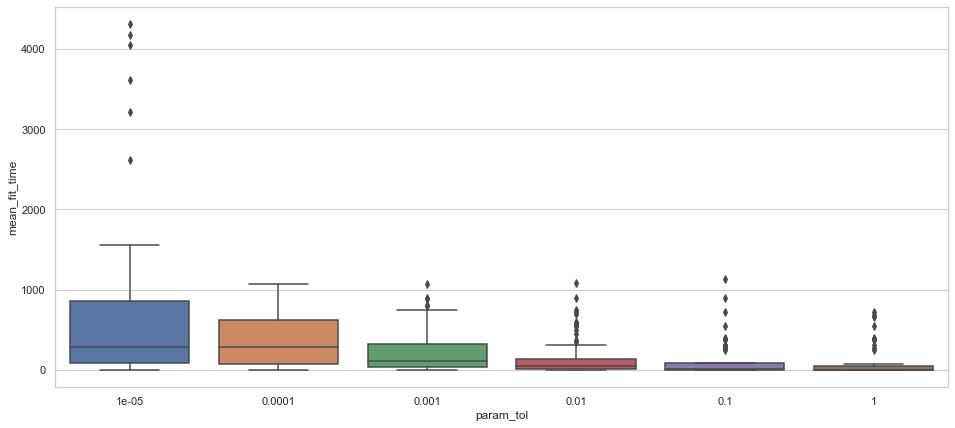

In [57]:
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(16, 7))
sns.boxplot(x="param_tol", y="mean_fit_time", data=svc_gridsearch)

**Bottom 10 parameters**

Reviewing the results, we found 108 models that did not return a `mean_test_score`.  We elected to replace those values with 0 in order to measure parameters effeciecy.

In [58]:
svc_gridsearch.loc[svc_gridsearch.mean_test_score.isna(),"mean_test_score"] = 0
svc_gridsearch[svc_columns].sort_values(by="rank_test_score").tail(10)

,param_C,param_loss,param_dual,param_tol,param_max_iter,mean_fit_time,mean_test_score,rank_test_score
76,0.001,hinge,False,0.1,1500,0.568480,0.0,423
77,0.001,hinge,False,1,1500,0.567813,0.0,424
78,0.001,hinge,False,1e-05,2000,0.520276,0.0,425
79,0.001,hinge,False,0.0001,2000,0.530914,0.0,426
80,0.001,hinge,False,0.001,2000,0.530581,0.0,427
81,0.001,hinge,False,0.01,2000,0.557176,0.0,428
82,0.001,hinge,False,0.1,2000,0.532908,0.0,429
83,0.001,hinge,False,1,2000,0.573466,0.0,430
86,0.001,hinge,False,0.001,3000,0.595407,0.0,431
85,0.001,hinge,False,0.0001,3000,0.558506,0.0,432


Parameters `C`, `loss`, and `dual` with values of 0.001, hinge, and False respectively, all failed to return a test score.  In order to learn what parameters are poorly performance, we analye using the below heatmap.

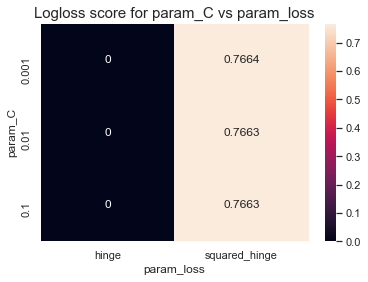

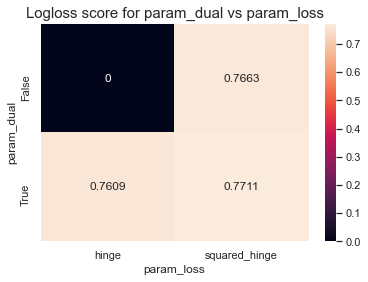

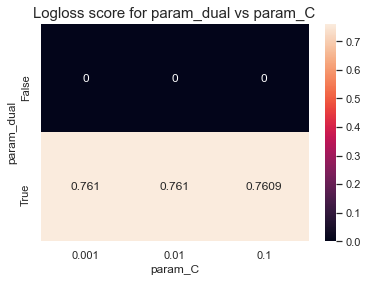

In [159]:
heatmapplot(svc_gridsearch,'param_C','param_loss', 'mean_test_score')
heatmapplot(svc_gridsearch,'param_dual','param_loss', 'mean_test_score')
heatmapplot(svc_gridsearch,'param_dual','param_C', 'mean_test_score')

*Heatmap provides min test score per combination.*

##### Further evalutaion of the issue suggested that "The combination of penalty='l2' and loss='hinge' are not supported when dual=False" by the model

Therefore: Below is the bottom scores, excluding zeros.

In [64]:
display( svc_gridsearch.loc[svc_gridsearch.mean_test_score > 0, svc_columns].sort_values(by="rank_test_score").tail(5))

print("The range for mean_test_score", \
      svc_gridsearch.mean_test_score.max() - svc_gridsearch.mean_test_score.min())

,param_C,param_loss,param_dual,param_tol,param_max_iter,mean_fit_time,mean_test_score,rank_test_score
298,0.1,hinge,True,0.1,2000,311.207234,0.760934,319
296,0.1,hinge,True,0.001,2000,315.751934,0.760934,319
295,0.1,hinge,True,0.0001,2000,316.313779,0.760934,319
294,0.1,hinge,True,1e-05,2000,320.693177,0.760934,319
297,0.1,hinge,True,0.01,2000,314.898139,0.760934,319


The range for mean_test_score 0.7715185606057678


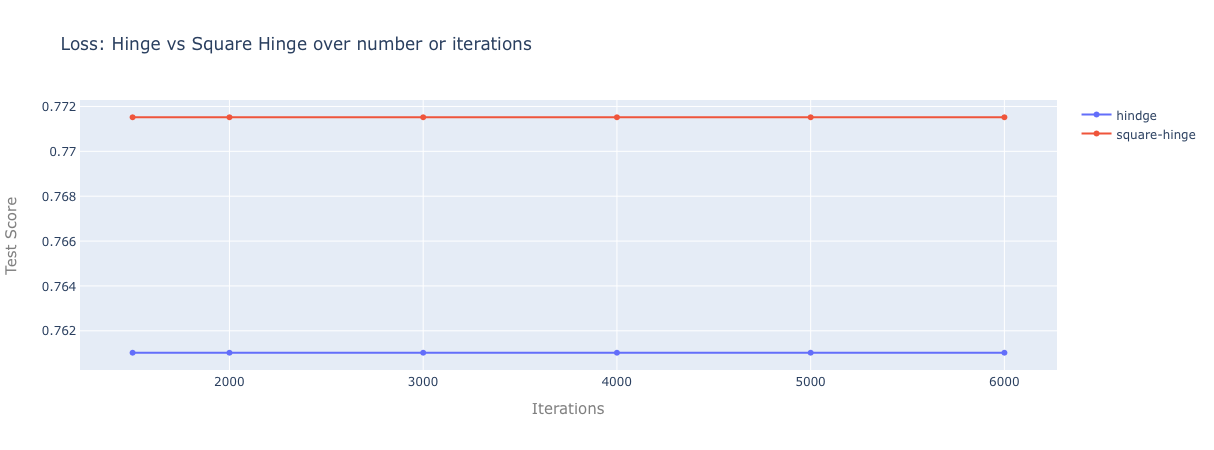

In [110]:
import plotly.graph_objs as go

fig = go.Figure()

graph_hindge = svc_gridsearch[svc_gridsearch.param_loss == 'hinge']
graph_hindge = graph_hindge.groupby(['param_max_iter'],sort='False')['mean_test_score'].max()
graph_hindge = graph_hindge.to_frame().reset_index()

graph_sqhinge = svc_gridsearch[svc_gridsearch.param_loss == 'squared_hinge']
graph_sqhinge = graph_sqhinge.groupby(['param_max_iter'],sort='False')['mean_test_score'].max()
graph_sqhinge = graph_sqhinge.to_frame().reset_index()

# Create traces
trace0 = go.Scatter(
    x = graph_hindge.param_max_iter,
    y = graph_hindge.mean_test_score,
    mode = 'lines+markers',
    name = 'hindge'
)
trace1 = go.Scatter(
    x = graph_sqhinge.param_max_iter,
    y = graph_sqhinge.mean_test_score,
    mode = 'lines+markers',
    name = 'square-hinge'
)

data = [trace0, trace1]

layout = go.Layout(
    
    title=go.layout.Title(
        text= 'Loss: Hinge vs Square Hinge over number or iterations',
        xref='container',
#         xanchor = 'center'
    ),
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text='Iterations',
            font=dict(
#                 family='Courier New, monospace',
                size=15,
                color='#7f7f7f'
            )
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text='Test Score',
            font=dict(
#                 family='Courier New, monospace',
                size=15,
                color='#7f7f7f'
            )
        )
    )
)

fig = go.Figure(data=data, layout=layout)

fig.show()


##### We wanted to check if the type of loss (hinge / squared ) makes any difference in the score, but as the above graphs shows, the score stayed constant over both the types of losses. The number of iterations did not matter. Square-hinge loss consistently have slightly better accuracy over hinge loss

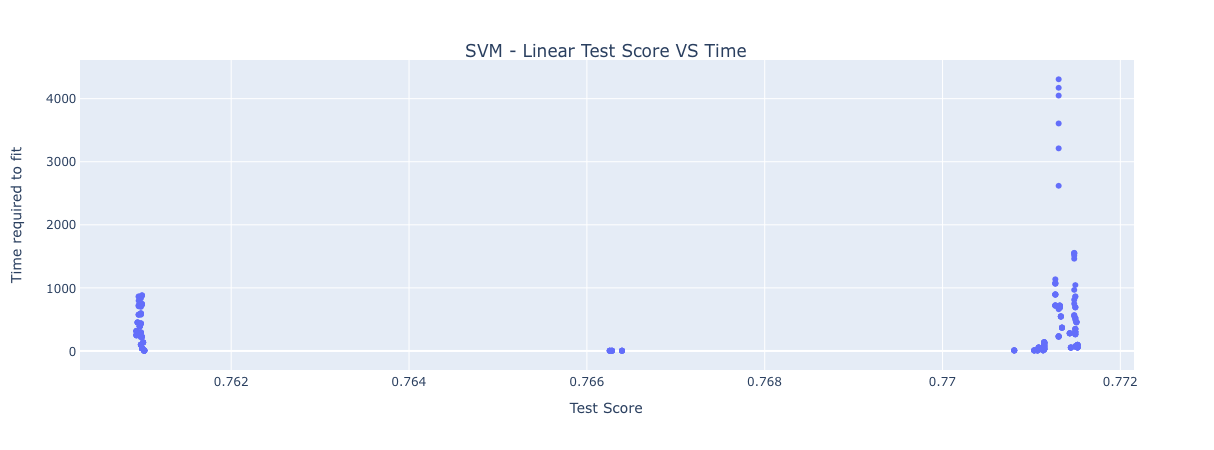

In [72]:
import plotly.express as px

fig = px.scatter(svc_gridsearch.loc[svc_gridsearch.mean_test_score > 0,:], x="mean_test_score", y="mean_fit_time")

fig.update_layout(xaxis_title="Test Score",
    yaxis_title="Time required to fit",
    title={
        'text': "SVM - Linear Test Score VS Time",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})


fig.show()

#### The range for the test score is minimal from the worst model to the best, with some of the poorest performance taking the longest to run. If you plot time vs. score we can see that we can get optimal performance without sacrificing time.

___

## Question 2

### Results

We use a a "out of fold predictions" technique to calculate log-loss and accuracy for our 3 models.  A strattified k-fold will be performed over 5 iterations.  For each hold out in the fold we will predict its value.

In [348]:
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# SVM Prep
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


rf_clf_param = CV_rf.best_params_
svm_clf_param = CV_svc.best_params_
xgb_best_param = xgboost_results.sort_values(by=["test-logloss-mean"], ascending=True).head(1).reset_index() \
    .T.loc[["gamma","max_depth","eta","min_child_weight","objective"],:].to_dict()[0]



**Stratified K-Fold**

The below plot shows how each fold each pull its out-hold value.

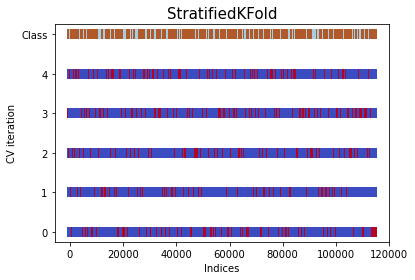

In [12]:
from sklearn.model_selection import StratifiedKFold

num_cv_iterations = 5
random_st = 42
kfold_cv = StratifiedKFold(
    n_splits=num_cv_iterations,
    shuffle=True,
    random_state = 123
)

fig, ax = plt.subplots()
cv_plot(ax, kfold_cv, X, y)

In [331]:
from sklearn.ensemble import RandomForestClassifier

rf_y_hat = np.zeros(len(y))
rf_y_hat_score = np.zeros(len(y))

for train, test in tqdm(kfold_cv.split(X,y), total=5):
    rf_clf = RandomForestClassifier(
        max_features=rf_clf_param["max_features"], 
        min_samples_leaf=rf_clf_param["min_samples_leaf"],
        n_estimators=rf_clf_param["n_estimators"],
        random_state=42, 
        n_jobs=-2)
    rf_clf.fit(X[train],y[train])
    rf_y_hat[test] = rf_clf.predict(X[test])
    rf_y_hat_score[test] = rf_clf.predict_proba(X[test])[:,1]


with open("data/rf_y_hat.pkl","wb") as f:
    pickle.dump((rf_y_hat, rf_y_hat_score), f)

100%|██████████| 5/5 [03:47<00:00, 45.46s/it]


In [339]:
from sklearn.svm import LinearSVC

svm_y_hat = np.zeros(len(y))

for train, test in tqdm(kfold_cv.split(X_scaled,y), total=5):
    svm_clf = LinearSVC(
        random_state=42,
        C = svm_clf_param["C"],
        dual = svm_clf_param["dual"],
        loss = svm_clf_param["loss"],
        max_iter = svm_clf_param["max_iter"],
        penalty = svm_clf_param["penalty"],
        tol = svm_clf_param["tol"]
    )
    svm_clf.fit(X_scaled[train],y[train])
    svm_y_hat[test] = rf_clf.predict(X[test])

    
with open("data/svm_y_hat.pkl","wb") as f:
    pickle.dump(svm_y_hat, f)

100%|██████████| 5/5 [01:25<00:00, 17.01s/it]


In [349]:
import xgboost as xgb

stopping = 3
boost_rounds = 30

xgb_y_hat = np.zeros(len(y))
xgb_y_hat_score = np.zeros(len(y))

for train, test in tqdm(kfold_cv.split(X_scaled,y), total=5):
    xgtrain = xgb.DMatrix(X[train], y[train])
    xgtest = xgb.DMatrix(X[test], y[test])

    bst = xgb.train(xgb_best_param, xgtrain)
    xgb_y_hat[test] = (bst.predict(xgtest) > .5)*1
    xgb_y_hat_score[test] = bst.predict(xgtest)

with open("data/xgb_y_hat.pkl","wb") as f:
    pickle.dump((xgb_y_hat, xgb_y_hat_score), f)

100%|██████████| 5/5 [00:19<00:00,  4.00s/it]


### Final Results

In [357]:
from sklearn.metrics import accuracy_score, log_loss

rf_y_hat, rf_y_hat_score = pickle.load(open("data/rf_y_hat.pkl","rb"))
svm_y_hat = pickle.load(open("data/svm_y_hat.pkl","rb"))
xgb_y_hat, xgb_y_hat_score = pickle.load(open("data/xgb_y_hat.pkl","rb"))

metric = [
    {
        "metric":"Accuracy",
        "XGBoost": accuracy_score(y, xgb_y_hat),
        "Random Forest": accuracy_score(y, rf_y_hat),
        "Support Vector Machine": accuracy_score(y, svm_y_hat)    
    },
    {
        "metric":"Log Loss",
        "XGBoost": log_loss(y, xgb_y_hat_score),
        "Random Forest": log_loss(y, rf_y_hat_score),
        "Support Vector Machine": None    
    }
]

pd.DataFrame(metric)

,metric,XGBoost,Random Forest,Support Vector Machine
0,Accuracy,0.781003,0.781799,0.807944
1,Log Loss,0.472091,0.467973,NaN


In our final model, we have found that SVM performed the best with an accuracy of 0.80. Tuning this model to get the optimal score took 8 hours and there should be a balance to determine what is the best model.  Reviewing log loss, we found the Random Forest model performed slight better.

____

## Question 3
### Support Vector Machine Scale-ing

In [120]:
%%capture

#### Data Read 

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df_data = pd.read_csv ("~/Dropbox/Case_Study_8/case_8.csv")
df_data.drop('v22',axis=1,inplace=True)

from tqdm import tqdm

data = [ pd.get_dummies(df_data[col], prefix=col).copy() for col in tqdm(columns) ]
one_hot_df = pd.concat(data, axis=1)

#Drop old columns
df_data_nc = df_data.drop(columns, axis=1)

df_data_final = pd.concat([df_data_nc, one_hot_df], axis=1)

df_data_encoded = reduce_features(df_data_final, True)

In [121]:
from sklearn.model_selection import cross_validate
SVC_Linear_tuned = LinearSVC(random_state=42,max_iter=7000,C=0.01,loss='squared_hinge',penalty='l2',dual=False,tol=0.01)

In [122]:
training_sizes = [1000,2000,5000,10000,20000,30000,40000]

In [124]:
%%capture

training_time = []

import time

for training_size in training_sizes:
    
    df_data_encoded_train = df_data_encoded.sample(training_size)
    
    print(len(df_data_encoded_train))
    
    labels_train = df_data_encoded_train.target
    
    df_data_encoded_X_train = df_data_encoded_train.drop(["ID","target"],axis = 1)
    
    df_enc_scaled_train = scaler.fit_transform(df_data_encoded_X_train)
    
    t0 = time.time()
    
#     SVC_Linear_tuned.fit(df_enc_scaled_train,labels_train)
    
    cross_validate(SVC_Linear_tuned,df_enc_scaled_train,labels_train,cv=5)
    
    t1 = time.time()

    training_time.append((t1-t0))

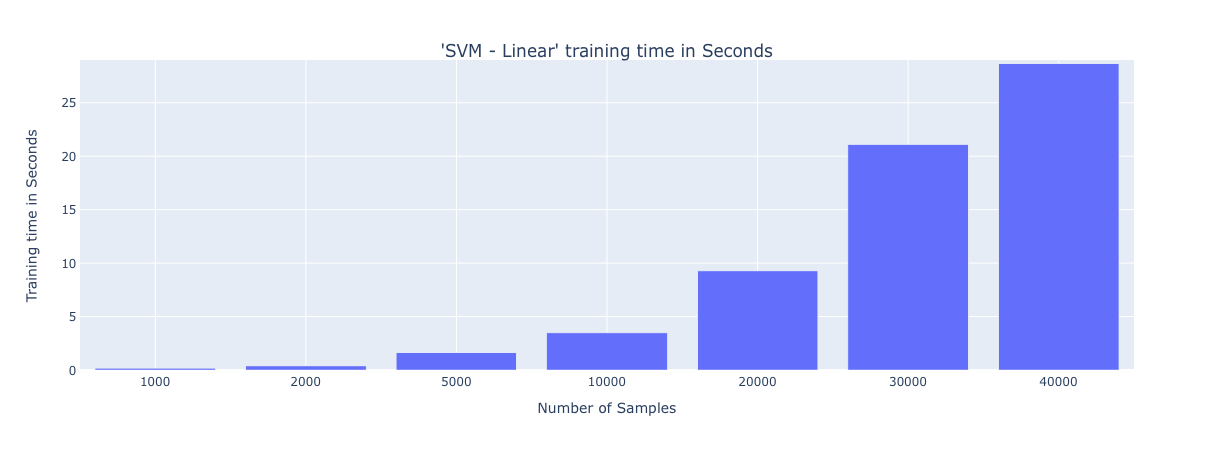

In [127]:
import plotly.express as px

fig = px.bar(x=training_sizes, y=training_time,range_y = [0,29])

fig.update_layout(xaxis_type='category',
                  xaxis_title="Number of Samples",
                  yaxis_title="Training time in Seconds",
                  title={
                        'text': "'SVM - Linear' training time in Seconds",
                        'y':0.9,
                        'x':0.5,
                        'xanchor': 'center',
                        'yanchor': 'top'})

fig.show()

### We can clearly see that the relationship is exponential 

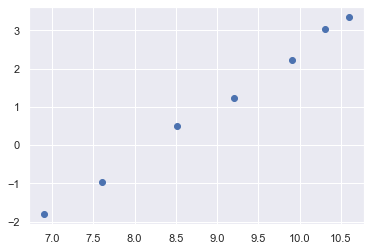

In [134]:
import matplotlib.pyplot as plt

plt.scatter(np.log(training_sizes),np.log(training_time))

plt.show()

In [135]:
### The Relationship looks linear now, lets see if we can interpret the relationship 

In [164]:
x = np.log(training_sizes)
y = np.log(training_time)

In [165]:
x = x.reshape(-1,1)
y = y.reshape(-1,1)

In [168]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
regressor = LinearRegression()  
regressor.fit(x, y) #training the algorithm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [170]:
### Regression Co-Eff
print(regressor.coef_)

[[1.40940926]]


#### This can be roughly interpreted as, for every 1% change in number of samples, the training - scaling time for SVM will go up by 1.41% 

## Appendix

* [Remove Highly Correlated Fields](#Remove-Highly-Correlated-Fields)
* [XGBoost Model](#XGBoost-Model)
* [Random Forsest Model](#Random-Forest-Model)
* [Support Vector Machine Model](#Support-Vector-Machine-Model)

In [154]:
import matplotlib.pyplot as plt

def heatmapplot(result,param1,param2, metric):
    min_scores = pd.DataFrame(result).groupby([param1, param2])[metric].min().unstack()
    sns.heatmap(min_scores, annot=True, fmt='.4g')
    
    plt.title('Logloss score for {} vs {}'.format(param1,param2), fontsize = 15) # title with fontsize 20
    plt.show()

#### Remove Highly Correlated Fields**

In [ ]:
import numpy as np
def reduce_features(df, verbose = False):
    # calculate the correlation matrix
    corr_matrix  = df.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
    
    #Get all of the correlation values > 95%
    x = np.where(upper > 0.95)

    #Display all field combinations with > 95% correlation
    cf = pd.DataFrame()
    cf['Field1'] = upper.columns[x[1]]
    cf['Field2'] = upper.index[x[0]]

    #Get the correlation values for every field combination. (There must be a more pythonic way to do this!)
    corr = [0] * len(cf)
    for i in range(0, len(cf)):
        corr[i] =  upper[cf['Field1'][i]][cf['Field2'][i]] 

    cf['Correlation'] = corr

    if( verbose ):
        print('There are ', str(len(cf['Field1'])), ' field correlations > 95%.')
        display(cf)
        
        print('Dropping the following ', str(len(to_drop)), ' highly correlated fields.')
        to_drop
        
    #Check columns before drop 
    if( verbose ):
        print('\r\n*********Before: Dropping Highly Correlated Fields*************************************')
        display(df.info(verbose=False))

    # Drop the highly correlated features from our training data 
    df = df.drop(to_drop, axis=1)

    #Check columns after drop 
    if( verbose ):
        print('\r\n*********After: Dropping Highly Correlated Fields**************************************')
        df.info(verbose=False)
    
    return df

#### XGBoost Model

In [ ]:
def trainXGBoost(param):
    stopping = 3
    boost_rounds = 30
    
    model = xgb.cv(
        param,
        xgtrain,
        nfold=3,
        metrics=(["logloss",'auc']),
        stratified=True,
        seed=123,
        num_boost_round=boost_rounds,
        early_stopping_rounds=stopping
    )
#     mean_logloss = model['test-logloss-mean'].min()
#     boost_rounds = model['test-logloss-mean'].argmin()
#     mean_auc =  model['test-auc-mean'].max()
#     auc_boost_round = model['test-auc-mean'].argmax()

    return pd.concat([pd.DataFrame([param]), model.tail(1).reset_index()], axis=1)
    
#     return {
#         'gamma':param["gamma"],
#         'max_depth':param["max_depth"],
#         "eta": param["eta"],
#         "min_child_weight":param["min_child_weight"],
#         "acc":mean_auc,
#         "logloss":mean_logloss,
#         "auc_boost_round": auc_boost_round,
#         "boost_rounds": boost_rounds
#     }

```
from tqdm import tqdm
result = list(map(trainXGBoost, tqdm(parameters)))
```

#### Random Forest Model

```
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

param_grid = {
    "max_features" : ["auto","log2",0.20, 0.30],
    "n_estimators" : [10,50,100],
    "min_samples_leaf" : [25, 50, 100]
}

rfc=RandomForestClassifier(random_state=42)
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=3,n_jobs = -2, verbose=1)
CV_rfc_mod = CV_rfc.fit(X_train, y_train)

pkl_filename = "CV_Random_Forest.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(CV_rfc, file)
```

#### Support Vector Machine Model

```
### Scale the Dataset 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
import sklearn.feature_selection as fs
from sklearn.model_selection import cross_val_score
import timeit
import pickle
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
import maatplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df_enc_scaled = scaler.fit_transform(case_8_reduced_feats.values)

X_train, X_test, y_train, y_test = train_test_split(df_enc_scaled, y,
        stratify=labels, 
        test_size=0.30,
        random_state=123)

# Gridsearch to determine the value of C
param_grid = {'C': [0.001,0.01,0.1],
              'loss': ['hinge', 'squared_hinge'],
              'penalty' : ['l2'],
              'dual' : [True,False],
              'tol': [0.00001,0.0001,0.001,0.01,0.1,1], #0.0001 is the Default
              'max_iter': [1500,2000,3000,4000,5000,6000],
             }

SVC_Linear = LinearSVC(random_state=42)
CV_svc = GridSearchCV(estimator = SVC_Linear, param_grid=param_grid, cv= 3, n_jobs = -1,verbose=1)
CV_svc_mod = CV_rfc.fit(X_train, y_train)

pkl_filename = "CV_SVM_Linear.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(CV_svc_mod, file)
```

In [9]:
#this analysis was inspired by the cv visualization found at https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py
from sklearn.model_selection import (KFold, ShuffleSplit, StratifiedKFold, StratifiedShuffleSplit)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

np.random.seed(42)
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

def cv_plot(ax, cv, X, y):
    plt.figure
    for i, (train_index, test_index) in enumerate(cv.split(X=X, y=y)):
        indices = np.array([np.nan] * len(X))
        indices[test_index] = 1
        indices[train_index] = 0        
        ax.scatter(range(len(indices)), [i+1] * len(indices), c=indices, marker='_', lw=10, cmap=cmap_cv)
   
    ax.scatter(range(len(indices)), [i+2] * len(indices), c=y, marker='_', lw=10, cmap=cmap_data)
    ytick = list(range(num_cv_iterations)) + ['Class']
    ax.set(yticks=np.arange(num_cv_iterations+1) + 1, yticklabels=ytick, xlabel='Indices', ylabel="CV iteration")
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

In [10]:
import numpy as np
def reduce_features(df, verbose = False):
    # calculate the correlation matrix
    corr_matrix  = df.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
    
    #Get all of the correlation values > 95%
    x = np.where(upper > 0.95)

    #Display all field combinations with > 95% correlation
    cf = pd.DataFrame()
    cf['Field1'] = upper.columns[x[1]]
    cf['Field2'] = upper.index[x[0]]

    #Get the correlation values for every field combination. (There must be a more pythonic way to do this!)
    corr = [0] * len(cf)
    for i in range(0, len(cf)):
        corr[i] =  upper[cf['Field1'][i]][cf['Field2'][i]] 

    cf['Correlation'] = corr

    if( verbose ):
        print('There are ', str(len(cf['Field1'])), ' field correlations > 95%.')
        display(cf)
        
        print('Dropping the following ', str(len(to_drop)), ' highly correlated fields.')
        to_drop
        
    #Check columns before drop 
    if( verbose ):
        print('\r\n*********Before: Dropping Highly Correlated Fields*************************************')
        display(df.info(verbose=False))

    # Drop the highly correlated features from our training data 
    df = df.drop(to_drop, axis=1)

    #Check columns after drop 
    if( verbose ):
        print('\r\n*********After: Dropping Highly Correlated Fields**************************************')
        df.info(verbose=False)
    
    return df